In [1]:
import glob
import os
import pandas as pd
import plotnine as p9
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, AutoMinorLocator

p9.theme_set(
    p9.theme_bw(base_size=10) +
    p9.theme(
        text=p9.element_text(family="P052", color="#000"),
        figure_size=(2.5, 2.5),
        axis_title=p9.element_text(size=10),
        axis_text=p9.element_text(size=8),
        legend_position="bottom",
        legend_text=p9.element_text(size=8),
        legend_title=p9.element_text(size=9),
        panel_grid_major=p9.element_line(size=0.3, color="#dddddd"),
        panel_grid_minor=p9.element_blank(),
        legend_justification_bottom=1,
        strip_background=p9.element_blank(),
        legend_margin=0,
    )
)

arch_names = {
    "attention": "Attention",
    "based": "Based",
    "base_conv": "BaseConv",
    "h3": "H3",
    "hyena": "Hyena",
    "mamba": "Mamba",
}

def read_df(dirs, filter_steps=5000):
    all_files = []
    for d in dirs:
        all_files.extend(list(glob.glob(d)))
    dfs = []
    for file in tqdm(all_files):
        dirname = os.path.dirname(file)
        evaluator = file.split("/")[-1].split(".")[0]
        split = dirname.split("/")[-1]
        arch, dim, lr = dirname.split("/")[-2].split(".")[0].split("___")
        log = pd.read_csv(file)
        log = log[(log["step"] % filter_steps) == 0]
        log["identifier"] = file
        log["arch"] = arch_names.get(arch, arch)
        log["dim"] = int(dim)
        log["lr"] = float(lr)
        log["evaluator"] = evaluator
        log["step_rel"] = log["step"] / log["step"].max()
        log["layers"] = 2
        log["dataset"] = dirname.split("/")[-3]
        log["split"] = split
        log = log.groupby(["variable", "step", "evaluator", "step_rel", "identifier", "arch", "dim", "lr", "layers", "dataset", "split"]).mean().reset_index()
        dfs.append(log)
    print(len(dfs))
    df = pd.concat(dfs)
    df = df.groupby(["variable", "step", "evaluator", "step_rel", "identifier", "arch", "dim", "lr", "layers", "dataset", "split"]).mean().reset_index()
    return df

In [2]:
dirs = [
    "../experiments/logs/ar_32/attention**/test/SummaryEvaluator.csv",
    # "../experiments/logs/ar_32_nope/attention**/test/SummaryEvaluator.csv",
    "../experiments/logs/ar_32_nope/h**/test/SummaryEvaluator.csv",
    "../experiments/logs/ar_32_nope/b**/test/SummaryEvaluator.csv",
    "../experiments/logs/ar_32_nope/m**/test/SummaryEvaluator.csv",
    "../experiments/logs/ar_32_more_lr/**/test/SummaryEvaluator.csv",
]
df = read_df(dirs)
df["arch"] = df.apply(lambda row: "Attention (NoPE)" if (row["arch"] == "Attention" and "_nope" in row["dataset"]) else row["arch"], axis=1)
df["dataset"] = "ar_32"

100%|██████████| 209/209 [00:15<00:00, 13.35it/s]


209


In [3]:
dirs = [
    "../experiments/logs/ar_32_reverse/**/test/SummaryEvaluator.csv",
]
df2 = read_df(dirs)
df2["dataset"] = "ar_32_reverse"

100%|██████████| 209/209 [00:11<00:00, 18.45it/s]


209


In [4]:
df = pd.concat([df, df2])
subset_df = df[(df["variable"] == "query_item.argmax") & (df["step_rel"] == 1.0)]
subset_df["dataset"] = subset_df["dataset"].apply(lambda x: x.replace("_nope", ""))
subset_df_best = subset_df[["dim", "arch", "value", "dataset"]].groupby(["dim", "arch", "dataset"]).max().reset_index()

pivoted = subset_df_best.copy()
pivoted
pivoted["value"] = pivoted["value"].apply(lambda x: f"{x * 100:.2f}".replace("%", "\%"))
pivoted = pivoted.pivot(index=["arch"], columns=["dataset", "dim"]).sort_index(axis=1)
print(pivoted.to_latex())

/tmp/user/23259/ipykernel_136953/3530768158.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


\begin{tabular}{lllllllllll}
\toprule
 & \multicolumn{10}{r}{value} \\
dataset & \multicolumn{5}{r}{ar_32} & \multicolumn{5}{r}{ar_32_reverse} \\
dim & 16 & 32 & 64 & 128 & 256 & 16 & 32 & 64 & 128 & 256 \\
arch &  &  &  &  &  &  &  &  &  &  \\
\midrule
Attention & 6.56 & 100.00 & 100.00 & 100.00 & 100.00 & 100.00 & 85.62 & 97.19 & 48.75 & 6.25 \\
BaseConv & 0.00 & 0.94 & 3.75 & 6.56 & 9.69 & 0.31 & 2.19 & 2.50 & 5.94 & 7.81 \\
Based & 24.38 & 93.12 & 99.06 & 98.75 & 99.06 & 31.56 & 95.00 & 98.12 & 90.00 & 20.00 \\
H3 & 0.94 & 0.62 & 1.88 & 2.50 & 1.56 & 0.31 & 0.31 & 0.94 & 1.56 & 0.62 \\
Hyena & 0.62 & 0.94 & 2.81 & 13.75 & 29.69 & 0.31 & 1.25 & 2.19 & 10.62 & 13.44 \\
Mamba & 10.00 & 76.88 & 80.62 & 89.69 & 91.25 & 16.88 & 58.13 & 75.94 & 91.88 & 96.56 \\
\bottomrule
\end{tabular}



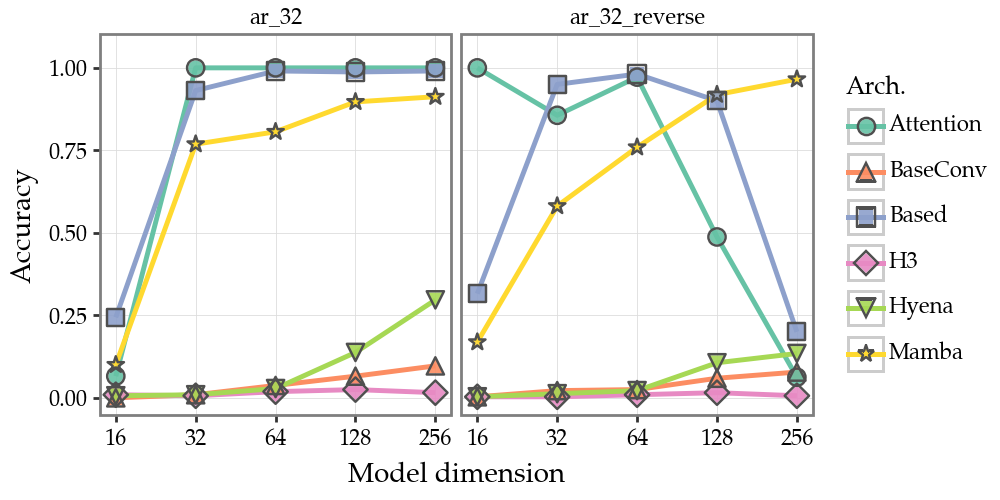

In [5]:
subset_df_best["clean"] = subset_df_best["value"].apply(lambda x: f"{x * 100:.2f}")

plot = (
    p9.ggplot(subset_df_best, p9.aes(x="dim", y="value", group="arch", color="arch", shape="arch")) +
    p9.geom_line(size=1) +
    p9.geom_point(size=3, stroke=0, alpha=0.9) +
    p9.geom_point(fill="none", stroke=0.5, size=3, color="#4f4f4f") +
    p9.facet_wrap("~dataset", scales="free_x") +
    p9.scale_x_log10(breaks=[16, 32, 64, 128, 256]) +
    p9.scale_y_continuous(limits=(0, 1.05)) +
    p9.labs(y="Accuracy", x="Model dimension", color="Arch.", shape="Arch.") +
    p9.scale_color_brewer(type='qual', palette='Set2') +
    p9.theme(
        figure_size=(5, 2.5),
        legend_position="right",
    )
)

plot.show()


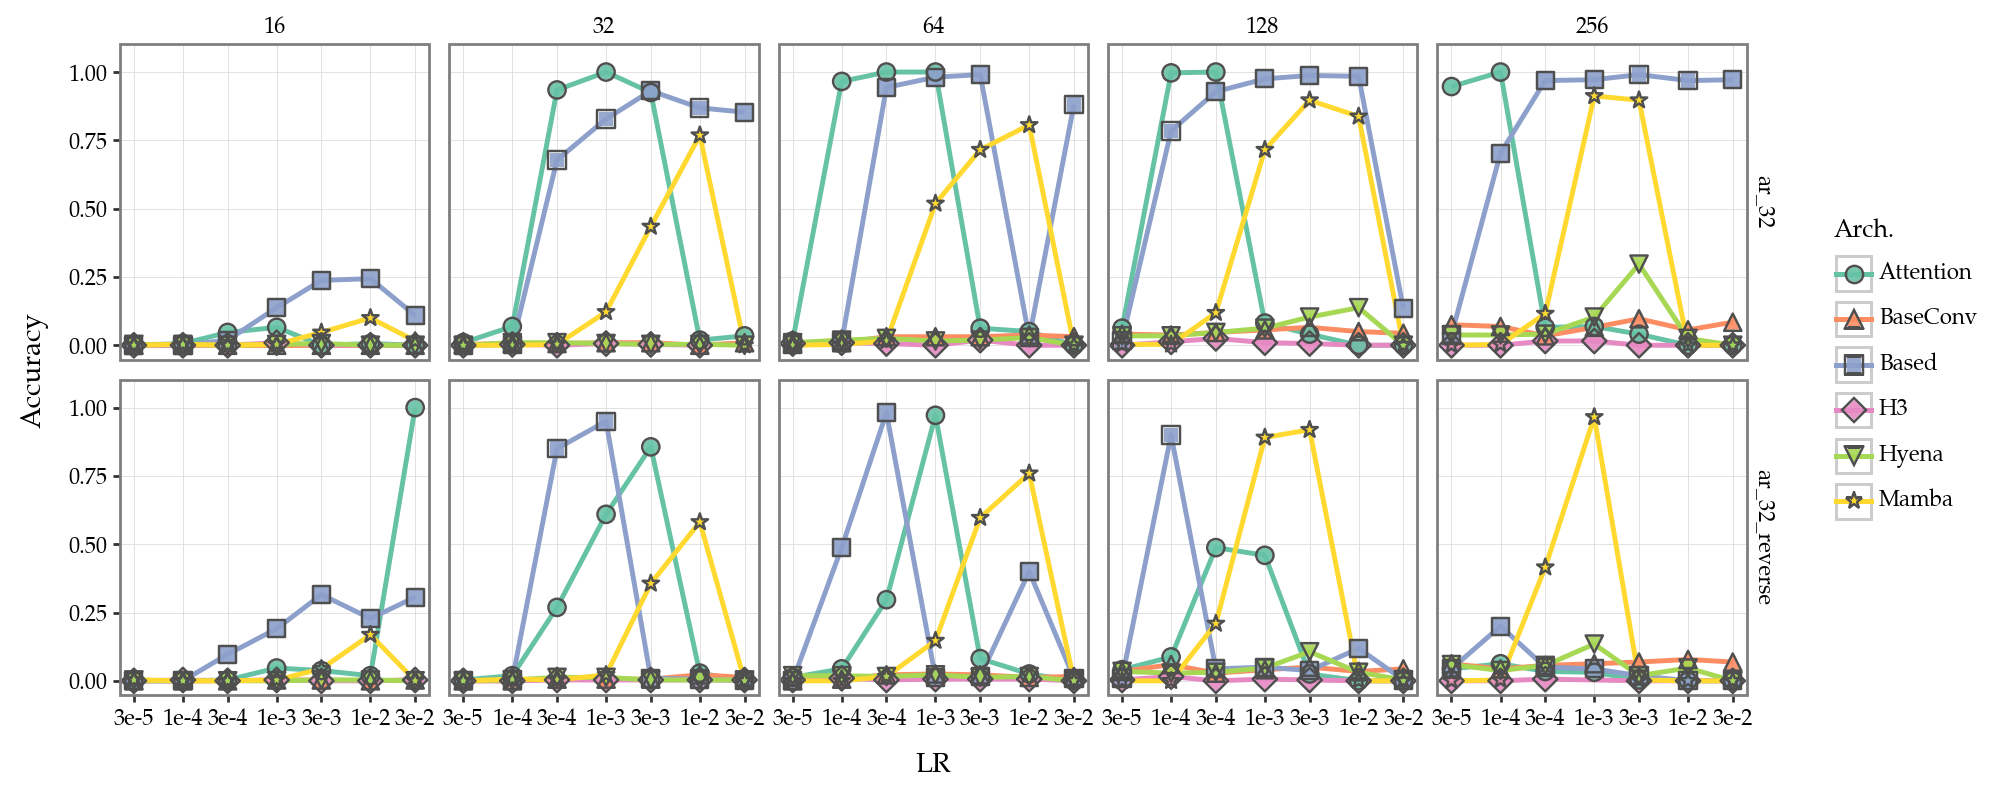

In [6]:
plot = (
    p9.ggplot(subset_df, p9.aes(x="lr", y="value", group="arch", color="arch", shape="arch")) +
    p9.geom_line(size=1) +
    p9.geom_point(size=3, stroke=0, alpha=0.9) +
    p9.geom_point(fill="none", stroke=0.5, size=3, color="#4f4f4f") +
    p9.facet_grid("dataset~dim", scales="free_x") +
    p9.scale_x_log10(breaks=[3e-5, 1e-4, 3e-4, 1e-3, 3e-3, 1e-2, 3e-2]) +
    p9.scale_y_continuous(limits=(0, 1.05)) +
    p9.labs(y="Accuracy", x="LR", color="Arch.", shape="Arch.") +
    p9.scale_color_brewer(type='qual', palette='Set2') +
    p9.theme(
        figure_size=(10, 4),
        legend_position="right",
    )
)

plot.show()


In [7]:
import pickle

AR_DATASET = "/nlp/scr/aryaman/tinylang/languages/ar_32.pkl"
AR_REVERSE_DATASET = "/nlp/scr/aryaman/tinylang/languages/ar_value_first/ar_32_value.pkl"

with open(AR_DATASET, "rb") as f:
    ar_dataset = pickle.load(f)

with open(AR_REVERSE_DATASET, "rb") as f:
    ar_reverse_dataset = pickle.load(f)

In [8]:
ar_dataset.prettify(ar_dataset.evalsets['test']['toks'][0])

'<bos> k3926 v1178 k3298 v3725 k2517 v2940 k565 v1864 k77 v2070 k2329 v3316 k653 v2580 k3250 v3084 k1312 v916 k3854 v630 k1585 v502 k1214 v3764 k3015 v3435 k96 v1161 k1726 v2208 k1701 v3089 <eos> k1312 v916 <eos>'

In [9]:
ar_reverse_dataset.prettify(ar_reverse_dataset.evalsets['test']['toks'][0])

'<bos> k1918 v3526 k517 v629 k1658 v2914 k745 v2444 k4094 v2212 k3699 v1212 k888 v811 k4089 v545 k3257 v1943 k3109 v4000 k1887 v2716 k476 v2860 k2277 v3455 k366 v238 k1546 v3373 k189 v3146 <eos> v3146 k189 <eos>'

In [10]:
positions = ["target_item_orig", "query_item_orig", "query_item", "divider"]

# get pivoted df
def get_attrib_df(df, df_int, corruption: str="query_item_orig", components: str | list[str]="block_input", prefix="KEY", max_layers=2):
    if isinstance(components, str):
        components = [components]
        
    subset_df = df[(df["variable"].isin(["query_item.argmax", "query_item.pred_prob"])) & (df["step_rel"] == 1.0)]
    subset_df_int = df_int[(df_int["step_rel"] == 1.0)]
    subset_df_int = pd.concat([subset_df_int, subset_df])
    subset_df_int = subset_df_int[["dim", "arch", "lr", "variable", "value", "dataset", "split"]].pivot(index=["dim", "arch", "lr", "dataset", "split"], columns="variable").reset_index()
    subset_df_int.columns = [col[1] if col[1] != '' else col[0] for col in subset_df_int.columns]
    
    for component in components:
        for layer in range(max_layers):
            for position in positions:
                metric = f"{layer}.{prefix}.{corruption}.{position}.{component}.restored_prob"
                if metric not in subset_df_int.columns:
                    continue
                corrupted = f"corrupted.{prefix}.{corruption}.{position}.{component}.restored_prob"
                diff = f"{layer}.{prefix}.{corruption}.{position}.{component}.prob_diff"
                original = f"original.{prefix}.{corruption}.{position}.{component}.restored_prob"
                kl_div = f"{layer}.{prefix}.{corruption}.{position}.{component}.kl_div"
                label = f"Association @ {layer}, {position}" if len(components) == 1 else f"Association @ {layer}, {position}, {component}"
                subset_df_int[label] = (subset_df_int[diff]) / (subset_df_int[original] - (subset_df_int[metric] - subset_df_int[diff]))
                
        for layer in range(max_layers):
            for position in positions:
                metric = f"{layer}.{prefix}.{corruption}.{position}.{component}.restored_prob"
                if metric not in subset_df_int.columns:
                    continue
                corrupted = f"corrupted.{prefix}.{corruption}.{position}.{component}.restored_prob"
                diff = f"{layer}.{prefix}.{corruption}.{position}.{component}.prob_diff"
                original = f"original.{prefix}.{corruption}.{position}.{component}.restored_prob"
                kl_div = f"{layer}.{prefix}.{corruption}.{position}.{component}.kl_div"
                suffix = f"{layer}, {position}" if len(components) == 1 else f"{layer}, {position}, {component}"
                subset_df_int = subset_df_int.rename(columns={
                    metric: f"Restored @ {suffix}",
                    corrupted: f"Corrupted @ {suffix}",
                    diff: f"Diff @ {suffix}",
                    original: f"Original @ {suffix}",
                    kl_div: f"KL @ {suffix}",
                })

    subset_df_int = subset_df_int.rename(columns={
        "query_item.argmax": "Accuracy",
        "query_item.pred_prob": "Likelihood",
    })

    return subset_df_int

In [11]:
dirs = [
    "../experiments/logs/ar_32/attention**/test/InterchangeEvaluator.csv",
    # "../experiments/logs/ar_32_nope/attention**/test/InterchangeEvaluator.csv",
    "../experiments/logs/ar_32_nope/h**/test/InterchangeEvaluator.csv",
    "../experiments/logs/ar_32_nope/b**/test/InterchangeEvaluator.csv",
    "../experiments/logs/ar_32_nope/m**/test/InterchangeEvaluator.csv",
    "../experiments/logs/ar_32_more_lr/**/test/InterchangeEvaluator.csv",
]
df_int = read_df(dirs)
df_int["dataset"] = "ar_32"

100%|██████████| 208/208 [00:57<00:00,  3.61it/s]


208


In [12]:
dirs = [
    "../experiments/logs/ar_32_reverse/**/test/InterchangeEvaluator.csv",
]
df_int2 = read_df(dirs)
df_int2["dataset"] = "ar_32_reverse"

100%|██████████| 42/42 [00:09<00:00,  4.54it/s]


42


In [13]:
df_int = pd.concat([df_int, df_int2])

In [16]:
df_int["variable"] = df_int["variable"].apply(lambda x: x.replace("VALUE", "KEY"))

In [17]:
subset_df_int = get_attrib_df(df, df_int)
subset_df_int_best = subset_df_int.iloc[subset_df_int.groupby(["dim", "arch", "dataset"])["Accuracy"].idxmax().dropna()].reset_index() # get most accurate ones

pivoted = subset_df_int_best.copy()[["dim", "arch", "dataset", "Association @ 1, target_item_orig"]]
pivoted["Association @ 1, target_item_orig"] = pivoted["Association @ 1, target_item_orig"].apply(lambda x: f"{x * 100:.2f}".replace("%", "\%"))
pivoted = pivoted.pivot(index=["arch"], columns=["dataset", "dim"]).sort_index(axis=1)
print(pivoted.to_latex())

\begin{tabular}{lllllllllll}
\toprule
 & \multicolumn{10}{r}{Association @ 1, target_item_orig} \\
dataset & \multicolumn{5}{r}{ar_32} & \multicolumn{5}{r}{ar_32_reverse} \\
dim & 16 & 32 & 64 & 128 & 256 & 16 & 32 & 64 & 128 & 256 \\
arch &  &  &  &  &  &  &  &  &  &  \\
\midrule
Attention & 220.13 & 100.00 & 100.00 & 100.00 & 100.00 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 \\
BaseConv & -3.24 & 35.89 & -148.30 & 67.26 & 204.15 & 0.00 & NaN & NaN & -0.00 & NaN \\
Based & 100.26 & 99.91 & 100.00 & 100.00 & 100.07 & NaN & NaN & NaN & NaN & NaN \\
H3 & -1.50 & -0.64 & 0.08 & 9.09 & 3.61 & NaN & NaN & NaN & NaN & NaN \\
Hyena & -0.15 & -0.62 & 0.01 & 0.00 & -0.00 & NaN & NaN & NaN & NaN & NaN \\
Mamba & -0.02 & 0.02 & 0.00 & 0.00 & 0.00 & NaN & NaN & NaN & NaN & NaN \\
\bottomrule
\end{tabular}



In [26]:
list(subset_df_int_plot.columns)

['dim',
 'arch',
 'lr',
 'dataset',
 'split',
 '0.KEY.query_item_orig.divider.attention_input.kl_div',
 '0.KEY.query_item_orig.divider.attention_input.logit_diff',
 '0.KEY.query_item_orig.divider.attention_input.max_perc',
 '0.KEY.query_item_orig.divider.attention_input.max_perc_layer',
 '0.KEY.query_item_orig.divider.attention_input.prob_diff',
 '0.KEY.query_item_orig.divider.attention_input.restored_logit',
 '0.KEY.query_item_orig.divider.attention_input.restored_prob',
 '0.KEY.query_item_orig.divider.attention_output.kl_div',
 '0.KEY.query_item_orig.divider.attention_output.logit_diff',
 '0.KEY.query_item_orig.divider.attention_output.max_perc',
 '0.KEY.query_item_orig.divider.attention_output.max_perc_layer',
 '0.KEY.query_item_orig.divider.attention_output.prob_diff',
 '0.KEY.query_item_orig.divider.attention_output.restored_logit',
 '0.KEY.query_item_orig.divider.attention_output.restored_prob',
 'KL @ 0, divider',
 '0.KEY.query_item_orig.divider.block_input.logit_diff',
 '0.KEY.

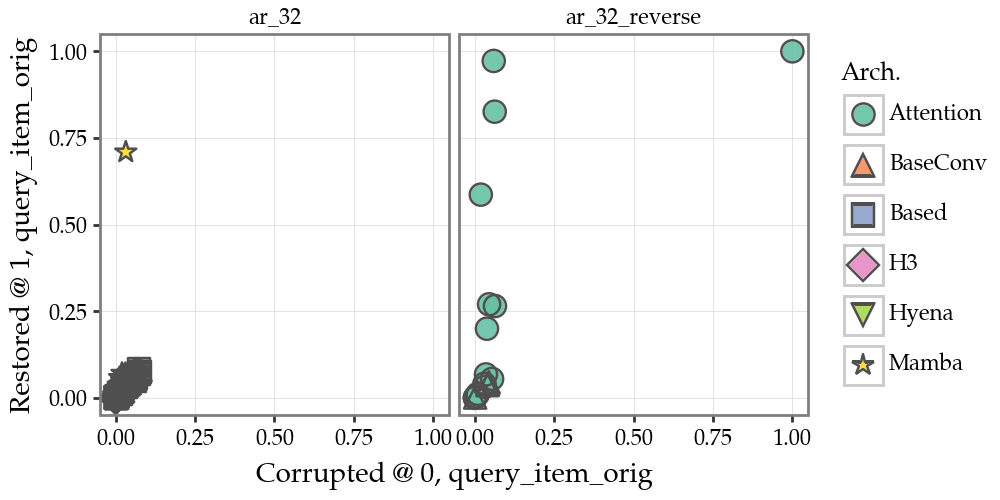

In [35]:
subset_df_int_plot = subset_df_int.copy()
subset_df_int_plot = subset_df_int_plot[(subset_df_int_plot["Original @ 0, target_item_orig"] - subset_df_int_plot["Corrupted @ 0, target_item_orig"]) > 0.00]
subset_df_int_plot["arch"] = pd.Categorical(subset_df_int_plot["arch"], categories=list(subset_df_int["arch"].unique()))
subset_df_int_plot["dim"] = pd.Categorical(subset_df_int_plot["dim"], categories=[x for x in sorted(subset_df_int_plot["dim"].unique())], ordered=True)
plot = (
    p9.ggplot(subset_df_int_plot, p9.aes(y="Restored @ 1, query_item_orig", x="Corrupted @ 0, query_item_orig", color="arch", group="arch", shape="arch")) +
    p9.facet_wrap("~dataset") +
    p9.geom_point(size=4, stroke=0, alpha=0.9) +
    p9.geom_point(fill="none", stroke=0.5, size=4, color="#4f4f4f") +
    p9.labs(color="Arch.", shape="Arch.") +
    p9.scale_color_brewer(type='qual', palette='Set2') +
    p9.theme(
        figure_size=(5, 2.5),
        # axis_text=p9.element_text(size=10),
        # axis_title=p9.element_text(size=12),
        legend_margin=0,
        legend_position="right",
    )
)
plot.show()